
# One-loop Bayesian Optimization

Steps:
1. Loads `ITRI-PY-1140908-training.csv`
2. Uses columns **MW01 ~ MWA** as features `X`
3. Uses columns **crack ~ temperature** as targets `y`
4. Builds a **Gaussian Process Regressor** (sklearn) 
5. Proposes **one candidate** via **Expected Improvement (EI)**

> Default behavior: **maximize** the first detected target (i.e., the leftmost column in `crack~temperature`).  
> Set `MINIMIZE=True` to flip the objective (e.g., if you want to minimize `crack`).


In [3]:

# ==== Configuration ====
CSV_PATH = "/Users/leo/Desktop/Project/itri_analysis_result/dataset/additional_dataset_20250908/ITRI-PY-1140908-training.csv"

# Set y
PRIMARY_TARGET = "yield(%)"

# If True, treat as minimization
MINIMIZE = False

# Number of random candidates
N_CANDIDATES = 20000
RANDOM_STATE = 42


In [4]:

import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

from typing import List

# pd.set_option("display.max_columns", None)


Simple EDA

In [5]:
df = pd.read_csv(CSV_PATH)

In [6]:
df.head()

,MW01,MW02,MW03,flux,MWA,crack,yield,temperature
0,800,800,300,2.0,5,85.00%,58.95%,291
1,800,800,210,1.5,10,85.00%,61.83%,294
2,700,900,270,0.5,15,84.00%,60.00%,295
3,800,600,280,1.5,10,85.00%,60.86%,290
4,700,900,300,1.5,15,85.00%,58.95%,291


In [7]:
# Remove %
df['crack'] = df['crack'].str.strip('%')
df['yield'] = df['yield'].str.strip('%')

# Trasfer all values to float
for col in df.columns:
    df[col] = df[col].apply(lambda value:float(value))

# Revise column name
new_col_name = {
    'crack': 'crack(%)', 
    'yield': 'yield(%)'
}
df = df.rename(columns=new_col_name)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MW01         100 non-null    float64
 1   MW02         100 non-null    float64
 2   MW03         100 non-null    float64
 3   flux         100 non-null    float64
 4   MWA          100 non-null    float64
 5   crack(%)     100 non-null    float64
 6   yield(%)     100 non-null    float64
 7   temperature  100 non-null    float64
dtypes: float64(8)
memory usage: 6.4 KB


In [9]:
df

,MW01,MW02,MW03,flux,MWA,crack(%),yield(%),temperature
0,800.0,800.0,300.0,2.0,5.0,85.0,58.95,291.0
1,800.0,800.0,210.0,1.5,10.0,85.0,61.83,294.0
2,700.0,900.0,270.0,0.5,15.0,84.0,60.00,295.0
3,800.0,600.0,280.0,1.5,10.0,85.0,60.86,290.0
4,700.0,900.0,300.0,1.5,15.0,85.0,58.95,291.0
...,...,...,...,...,...,...,...,...
95,800.0,600.0,590.0,0.5,10.0,85.0,57.00,288.0
96,900.0,900.0,750.0,1.5,5.0,84.0,56.00,287.0
97,600.0,700.0,670.0,1.0,20.0,85.0,57.00,290.0
98,900.0,900.0,540.0,2.0,10.0,84.0,57.00,288.0


In [10]:
df.describe()

,MW01,MW02,MW03,flux,MWA,crack(%),yield(%),temperature
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000
mean,750.000000,750.000000,435.800000,1.250000,12.500000,84.290000,58.53120,292.250000
std,112.366644,112.366644,188.648463,0.561833,5.618332,0.686007,1.78767,4.344682
min,600.000000,600.000000,160.000000,0.500000,5.000000,82.000000,56.00000,285.000000
25%,675.000000,675.000000,277.500000,0.875000,8.750000,84.000000,57.00000,289.000000
50%,750.000000,750.000000,410.000000,1.250000,12.500000,84.000000,58.00000,292.000000
75%,825.000000,825.000000,570.000000,1.625000,16.250000,85.000000,59.97750,295.000000
max,900.000000,900.000000,800.000000,2.000000,20.000000,85.000000,62.00000,304.000000


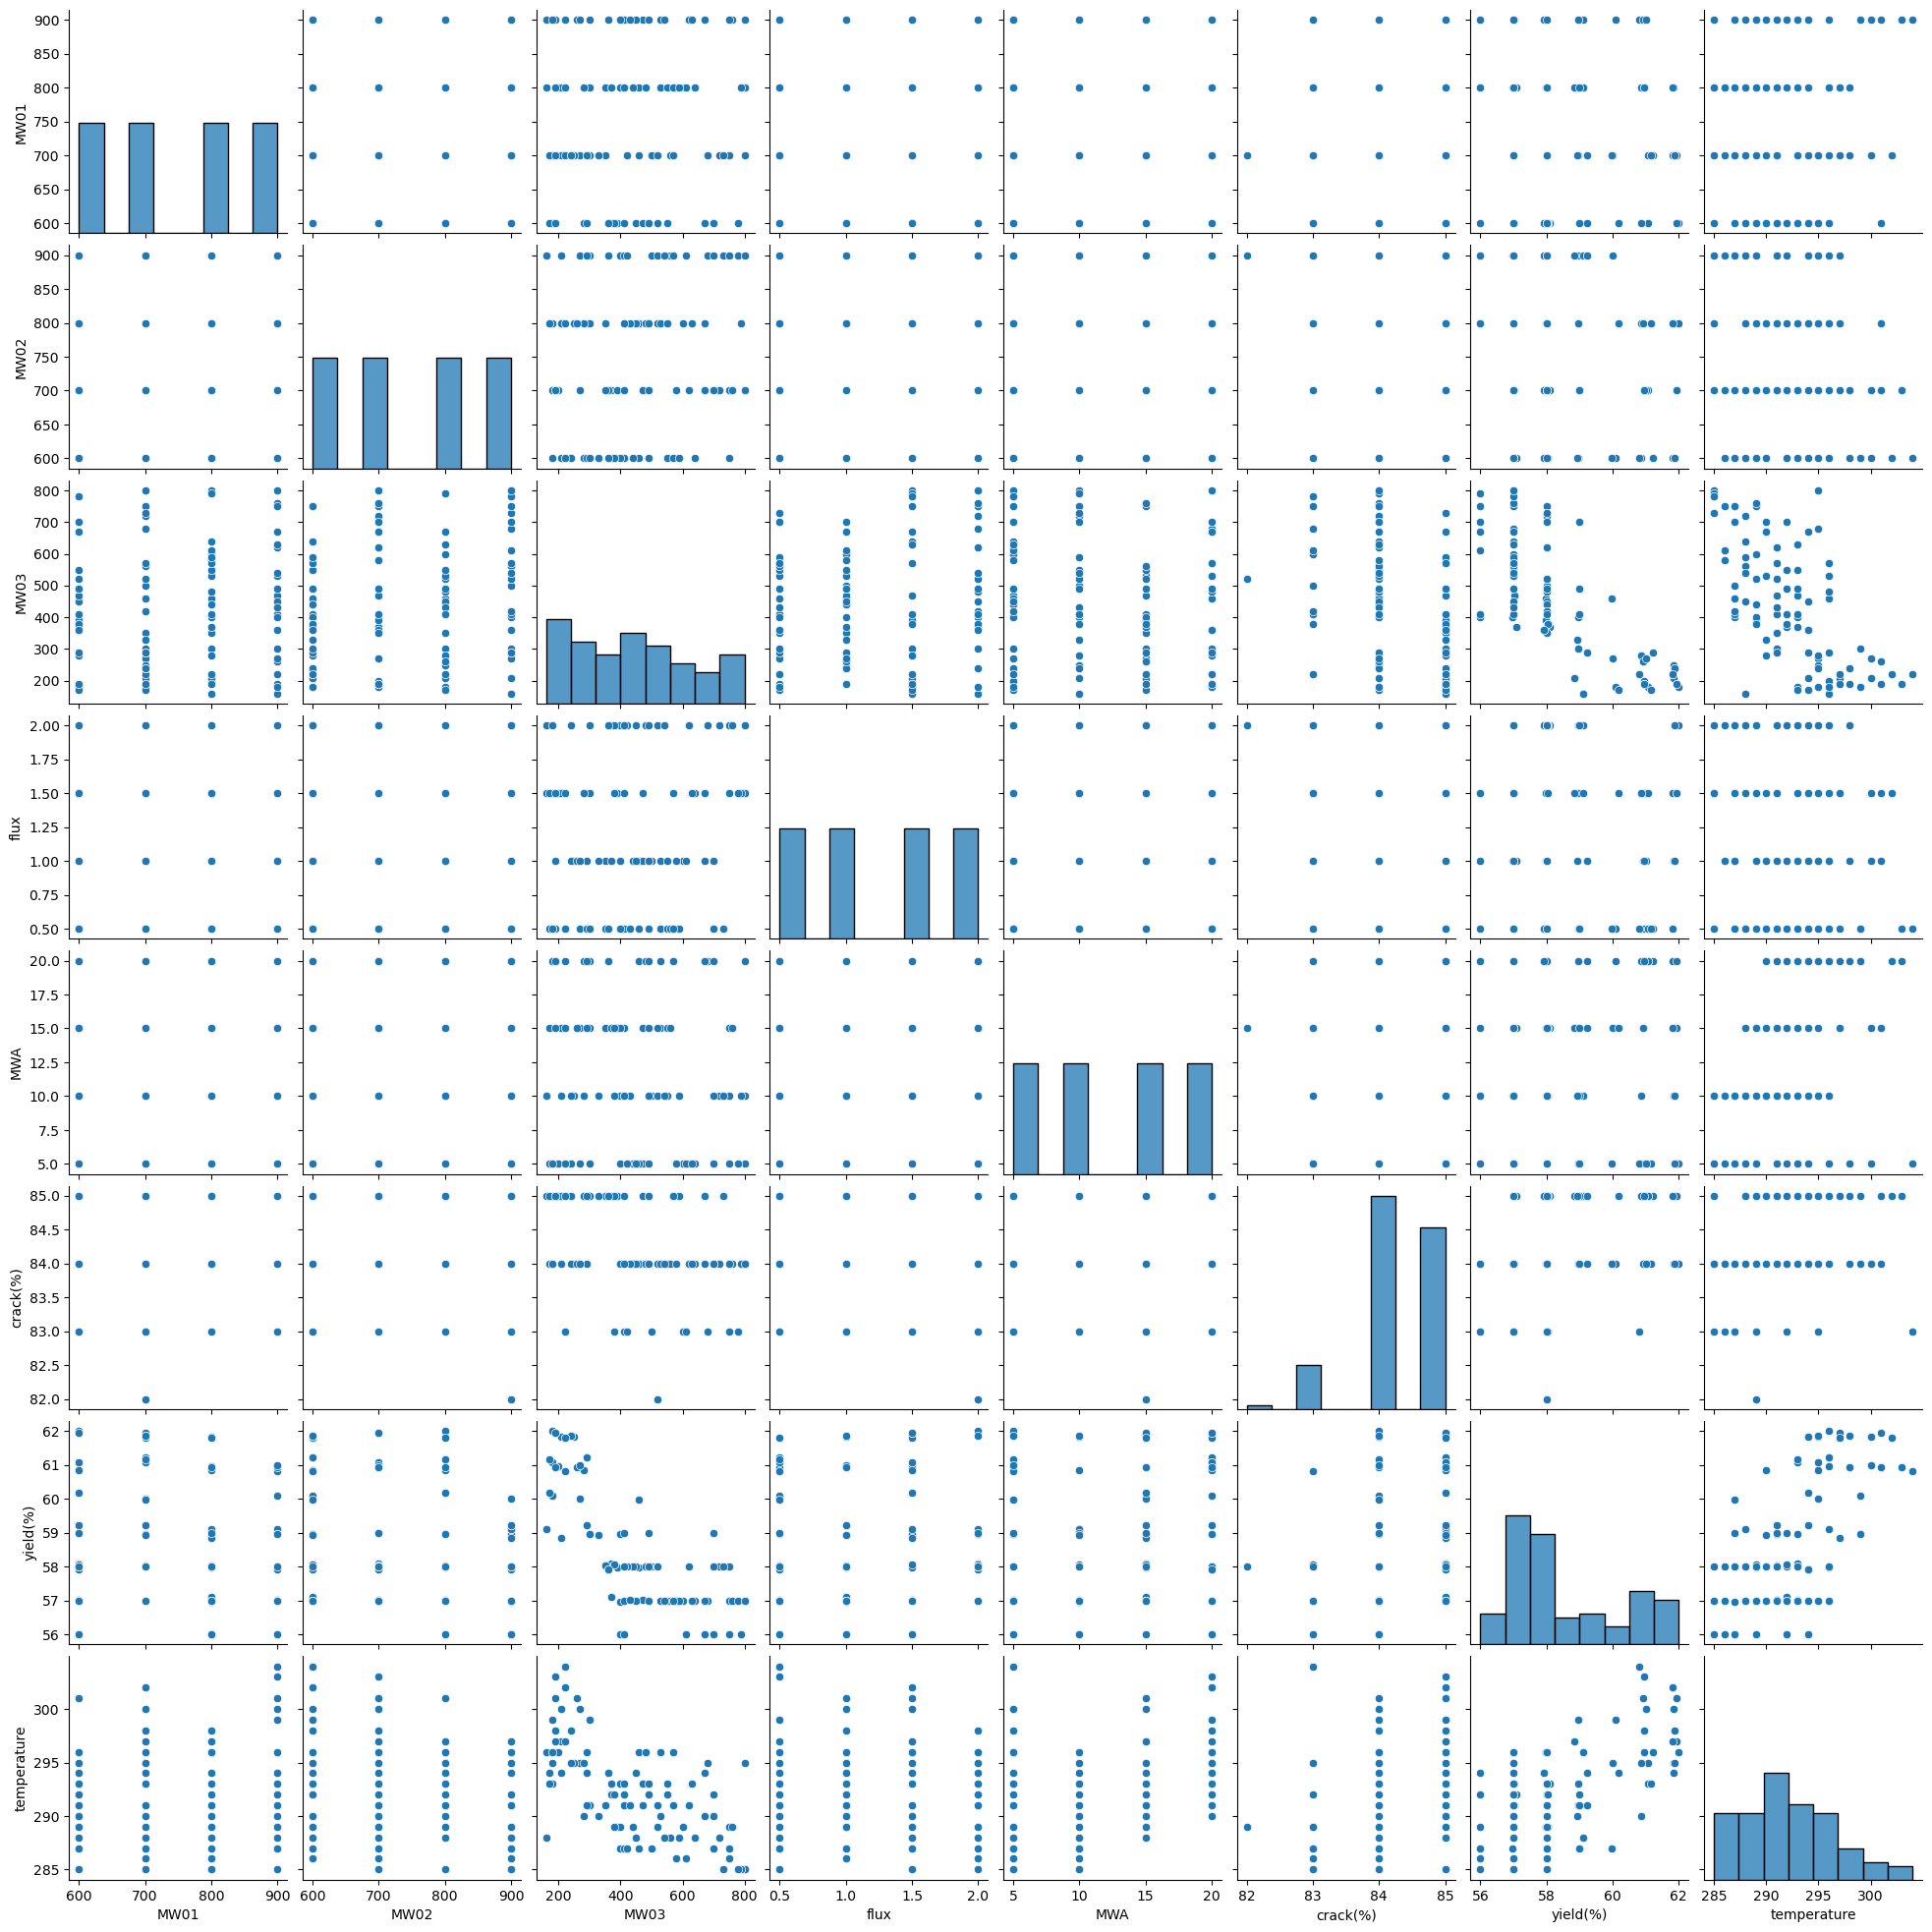

In [11]:
sns.pairplot(df)
plt.show()

In [12]:
def expected_improvement(mu, sigma, y_best, xi: float = 0.01):
    sigma = np.maximum(sigma, 1e-12)
    improv = mu - y_best - xi
    Z = improv / sigma
    ei = improv * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei = np.where(sigma <= 1e-12, 0.0, ei)
    return ei


In [13]:
X = df.iloc[:, :-3]
y = df.loc[:, PRIMARY_TARGET]

In [14]:
kernel = (ConstantKernel(1.0, (1e-3, 1e3)) *
          RBF(length_scale=np.ones(X.shape[1]), length_scale_bounds=(1e-2, 1e3)) +
          WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-8, 1e1)))

gpr = GaussianProcessRegressor(kernel=kernel,
                               n_restarts_optimizer=5,
                               random_state=0,
                               normalize_y=True)

x_scaler = StandardScaler()
Xs = x_scaler.fit_transform(X)

gpr.fit(Xs, y)
print("Fitted kernel:", gpr.kernel_)


Fitted kernel: 0.802**2 * RBF(length_scale=[3.2, 2.31, 0.438, 1.66, 1e+03]) + WhiteKernel(noise_level=0.0499)


/Users/leo/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [15]:
# Generate candidates
rng = np.random.RandomState(RANDOM_STATE)
low, high = X.min(axis=0), X.max(axis=0)
X_cand = rng.uniform(low, high, size=(20000, X.shape[1]))
X_cand_s = x_scaler.transform(X_cand)

# Prediction
mu, std = gpr.predict(X_cand_s, return_std=True)
y_best = np.max(y)

/Users/leo/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [16]:
ei = expected_improvement(mu, std, y_best, xi=0.01)
idx = int(np.argmax(ei))

x_next = X_cand[idx]
mu_next = mu[idx].astype(float)
std_next = std[idx].astype(float)
ei_next = ei[idx].astype(float)

pred_mean_target = -mu_next if MINIMIZE else mu_next

candidate_df = pd.DataFrame([x_next], columns=X.columns)
candidate_df["pred_mean"] = pred_mean_target
candidate_df["pred_std"] = std_next
candidate_df["EI"] = ei_next
candidate_df["objective"] = PRIMARY_TARGET
candidate_df["assumption"] = "minimization" if MINIMIZE else "maximization"

candidate_df


,MW01,MW02,MW03,flux,MWA,pred_mean,pred_std,EI,objective,assumption
0,620.724587,689.545187,223.591398,1.788739,17.268058,62.357161,0.496226,0.418109,yield(%),maximization


In [20]:
ei.shape

(20000,)

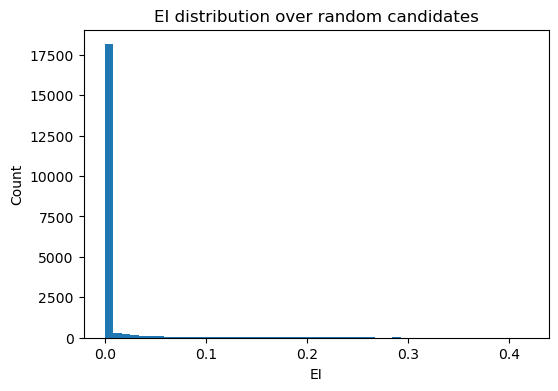

In [25]:
plt.figure(figsize=(6,4))
plt.hist(ei, bins=50)
plt.title("EI distribution over random candidates")
plt.xlabel("EI")
plt.ylabel("Count")
plt.show()

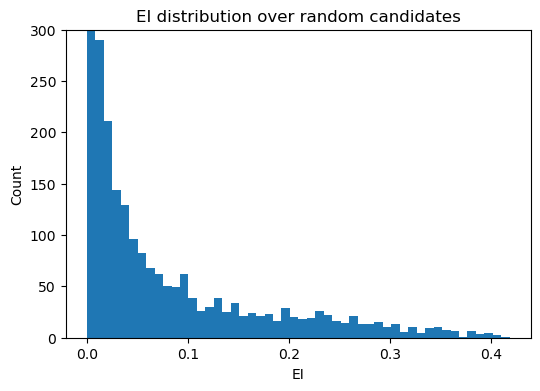

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(ei, bins=50)
plt.title("EI distribution over random candidates")
plt.xlabel("EI")
plt.ylabel("Count")
plt.ylim(0, 200)
plt.show()


In [18]:

# OUT_CSV = "/mnt/data/next_candidate.csv"
# candidate_df.to_csv(OUT_CSV, index=False)
# print("Saved candidate to:", OUT_CSV)
